# Milestone 1 - Predicting Potentially Hazardous Near-Earth Asteroids

Authors: Jerry Jin, Malcolm Maxwell, Sadie Lee

## Summary

## Introduction

**Background**
Astronomers monitor and identify asteroids as a means to classify those that may pose a threat to Earth and humanity. Specifically, near-earth asteroids (NEAs), those whose orbits bring them relatively close to Earth, are a primary focus of this monitoring. While most are harmless, some of these asteroids are referred to as potentially hazardous (PHAs), as certain characteristics (such as an asteroid’s minimum orbit intersection distance with Earth and its size) determine an asteroid's potential risk of impact. This classification of PHAs is valuable for both planetary science and defense, since even small asteroids can cause serious harm if they entered into our atmosphere.

**Question**
Can orbital and physical characteristics of near-Earth asteroids be used to accurately predict whether an asteroid is classified as potentially hazardous?

**Dataset**
This project uses the Small-Body DataBase (SBDB) from NASA JPL [[1]](#References). Specifically, we use only near-earth asteroids rather than all objects for speed and efficiency. Variables were chosen based on available data, i.e., if a significant percentage of a variable was missing for the defined scope (near-earth asteroids), the variable was not included in the API call. The dataset retrieved from the API contains the following variables:


| Variable    | Type        | Description |
| ----------- | ----------- | ----------- |
| spkid      | int64       |  Object primary ID |
| full_name   | str        |  Object full name/designation |
| pdes   | str        |  Object primary designation |
| orbit_id   | str        |  Orbit solution ID |
| pha   | int64        |  Potentially hazardous asteroid flag (target), 1 indicates PHA, 0 indicates not PHA |
| moid_ld   | float64        |  Earth minimum orbit intersection distance, renamed to `min_orbit_intersection_dist` |
| epoch   | float64        |  Epoch of osculation in Julian day form |
| e   | float64        |  Eccentricity, renamed to `eccentricity` |
| a   | float64        |  Semi-major axis, renamed to `semi_major_axis` |
| q   | float64        |  Perihelion distance, renamed to `perihelion_dist` |
| i   | float64        |  Inclination (angle w.r.t. the x-y ecliptic plane), renamed to `inclination` |
| ma   | float64        |  Mean anomaly in degrees, renamed to `mean_anomaly` |
| tp   | float64        |  Time of perihelion passage, renamed to `time_of_perihelion_passsage` |
| H   | float64        |  Absolute magnitude parameter, renamed to `abs_magnitude` |

## Methods & results

### Imports and setup

In [ ]:
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from scipy.stats import randint

In [22]:
# Set seed
np.random.seed(1)

### Fetch data

In [3]:
# Base API URL
base_url = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"

# Define fields
fields = [
    "spkid", "full_name", "pdes", "orbit_id",
    "pha", "moid_ld", "epoch",
    "e", "a", "q", "i", "ma", "tp", "H",
]

params = {
    "sb-kind": "a",
    "sb-group": "neo", # near earth objects only
    "fields": ",".join(fields)
}

# Send request
response = requests.get(base_url, params=params)
response.raise_for_status()

data = response.json()

# Extract records
records = data.get("data", [])

df = pd.DataFrame(records, columns=fields)
print(df.head()) # Check
print(len(df))
df.to_csv("../data/raw/asteroid_data_raw.csv", index=False) # Save

      spkid                 full_name  pdes  orbit_id pha moid_ld      epoch  \
0  20000433        433 Eros (A898 PA)   433   JPL 659   N    57.7  2461000.5   
1  20000719      719 Albert (A911 TB)   719   JPL 274   N    78.3  2461000.5   
2  20000887      887 Alinda (A918 AA)   887   JPL 730   N      31  2461000.5   
3  20001036    1036 Ganymed (A924 UB)  1036  JPL 1460   N     134  2461000.5   
4  20001221      1221 Amor (1932 EA1)  1221   JPL 143   N      42  2461000.5   

        e      a      q      i      ma          tp      H  
0  0.2228  1.458  1.133  10.83  310.55  2461088.83  10.38  
1  0.5466  2.637  1.195  11.57  240.61  2461519.09  15.59  
2  0.5712  2.474  1.061   9.40   81.54  2460678.64  13.81  
3  0.5332  2.665  1.244  26.68   97.59  2460569.72   9.18  
4  0.4346   1.92  1.085  11.87   59.87  2460838.91  17.37  
40844


### Clean data

In [2]:
# Read data
df = pd.read_csv('../data/raw/asteroid_data_raw.csv')
df.head()

,spkid,full_name,pdes,orbit_id,pha,moid_ld,epoch,e,a,q,i,ma,tp,H
0,20000433,433 Eros (A898 PA),433,JPL 659,N,57.7,2461000.5,0.2228,1.458,1.133,10.83,310.55,2461088.83,10.38
1,20000719,719 Albert (A911 TB),719,JPL 274,N,78.3,2461000.5,0.5466,2.637,1.195,11.57,240.61,2461519.09,15.59
2,20000887,887 Alinda (A918 AA),887,JPL 730,N,31.0,2461000.5,0.5712,2.474,1.061,9.40,81.54,2460678.64,13.81
3,20001036,1036 Ganymed (A924 UB),1036,JPL 1460,N,134.0,2461000.5,0.5332,2.665,1.244,26.68,97.59,2460569.72,9.18
4,20001221,1221 Amor (1932 EA1),1221,JPL 143,N,42.0,2461000.5,0.4346,1.920,1.085,11.87,59.87,2460838.91,17.37


In [3]:
# Rename columns to more descriptive

df = df.rename(columns={
    'moid_ld': 'min_orbit_intersection_dist',
    'e': 'eccentricity',
    'a': 'semi_major_axis',
    'q': 'perihelion_dist',
    'i': 'inclination',
    'ma': 'mean_anomaly',
    'tp': 'time_of_perihelion_passage',
    'H': 'abs_magnitude'
})

df.head()

,spkid,full_name,pdes,orbit_id,pha,min_orbit_intersection_dist,epoch,eccentricity,semi_major_axis,perihelion_dist,inclination,mean_anomaly,time_of_perihelion_passage,abs_magnitude
0,20000433,433 Eros (A898 PA),433,JPL 659,N,57.7,2461000.5,0.2228,1.458,1.133,10.83,310.55,2461088.83,10.38
1,20000719,719 Albert (A911 TB),719,JPL 274,N,78.3,2461000.5,0.5466,2.637,1.195,11.57,240.61,2461519.09,15.59
2,20000887,887 Alinda (A918 AA),887,JPL 730,N,31.0,2461000.5,0.5712,2.474,1.061,9.40,81.54,2460678.64,13.81
3,20001036,1036 Ganymed (A924 UB),1036,JPL 1460,N,134.0,2461000.5,0.5332,2.665,1.244,26.68,97.59,2460569.72,9.18
4,20001221,1221 Amor (1932 EA1),1221,JPL 143,N,42.0,2461000.5,0.4346,1.920,1.085,11.87,59.87,2460838.91,17.37


In [4]:
# Drop rows where PHA is NA
# PHA is target variable

df.dropna(subset=['pha'], inplace=True)

In [5]:
# Convert PHA values to boolean

pha_map = {'Y': 1, 'N': 0}
df['pha'] = df['pha'].map(pha_map)

In [6]:
# Clean and standardize full name
# Remove parentheses
# Replace spaces with underscores
# Clean edge underscores if any

df['full_name'] = df['full_name'].str.replace(r"[()]", "", regex=True).str.replace(r"\s+", "_", regex=True).str.strip("_")

In [7]:
df.head()

,spkid,full_name,pdes,orbit_id,pha,min_orbit_intersection_dist,epoch,eccentricity,semi_major_axis,perihelion_dist,inclination,mean_anomaly,time_of_perihelion_passage,abs_magnitude
0,20000433,433_Eros_A898_PA,433,JPL 659,0,57.7,2461000.5,0.2228,1.458,1.133,10.83,310.55,2461088.83,10.38
1,20000719,719_Albert_A911_TB,719,JPL 274,0,78.3,2461000.5,0.5466,2.637,1.195,11.57,240.61,2461519.09,15.59
2,20000887,887_Alinda_A918_AA,887,JPL 730,0,31.0,2461000.5,0.5712,2.474,1.061,9.40,81.54,2460678.64,13.81
3,20001036,1036_Ganymed_A924_UB,1036,JPL 1460,0,134.0,2461000.5,0.5332,2.665,1.244,26.68,97.59,2460569.72,9.18
4,20001221,1221_Amor_1932_EA1,1221,JPL 143,0,42.0,2461000.5,0.4346,1.920,1.085,11.87,59.87,2460838.91,17.37


In [8]:
# Missing data summary

missing_summary = df.isnull().sum()
print("Missing values per column:")
print(missing_summary[missing_summary >= 0])

Missing values per column:
spkid                          0
full_name                      0
pdes                           0
orbit_id                       0
pha                            0
min_orbit_intersection_dist    0
epoch                          0
eccentricity                   0
semi_major_axis                0
perihelion_dist                0
inclination                    0
mean_anomaly                   0
time_of_perihelion_passage     0
abs_magnitude                  3
dtype: int64


Not significant missing data, given that we chose variables in the API call that did not have significantly missing data. We will just drop rows without `abs_magnitude` (only 3 rows out of 40713).

In [9]:
df.dropna(subset=['abs_magnitude'], inplace=True)

In [10]:
# Save cleaned data to data/processed

df.to_csv('../data/processed/asteroid_data_clean.csv', index=False)

### Exploratory data analysis

In [2]:
# Read clean data

asteroids = pd.read_csv('../data/processed/asteroid_data_clean.csv')
asteroids.head()

,spkid,full_name,pdes,orbit_id,pha,min_orbit_intersection_dist,epoch,eccentricity,semi_major_axis,perihelion_dist,inclination,mean_anomaly,time_of_perihelion_passage,abs_magnitude
0,20000433,433_Eros_A898_PA,433,JPL 659,0,57.7,2461000.5,0.2228,1.458,1.133,10.83,310.55,2461088.83,10.38
1,20000719,719_Albert_A911_TB,719,JPL 274,0,78.3,2461000.5,0.5466,2.637,1.195,11.57,240.61,2461519.09,15.59
2,20000887,887_Alinda_A918_AA,887,JPL 730,0,31.0,2461000.5,0.5712,2.474,1.061,9.40,81.54,2460678.64,13.81
3,20001036,1036_Ganymed_A924_UB,1036,JPL 1460,0,134.0,2461000.5,0.5332,2.665,1.244,26.68,97.59,2460569.72,9.18
4,20001221,1221_Amor_1932_EA1,1221,JPL 143,0,42.0,2461000.5,0.4346,1.920,1.085,11.87,59.87,2460838.91,17.37


In [17]:
asteroids.shape

(40710, 14)

In [12]:
asteroids.info()

<class 'pandas.DataFrame'>
RangeIndex: 40710 entries, 0 to 40709
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   spkid                        40710 non-null  int64  
 1   full_name                    40710 non-null  str    
 2   pdes                         40710 non-null  str    
 3   orbit_id                     40710 non-null  str    
 4   pha                          40710 non-null  int64  
 5   min_orbit_intersection_dist  40710 non-null  float64
 6   epoch                        40710 non-null  float64
 7   eccentricity                 40710 non-null  float64
 8   semi_major_axis              40710 non-null  float64
 9   perihelion_dist              40710 non-null  float64
 10  inclination                  40710 non-null  float64
 11  mean_anomaly                 40710 non-null  float64
 12  time_of_perihelion_passage   40710 non-null  float64
 13  abs_magnitude              

In [13]:
asteroids.describe()

,spkid,pha,min_orbit_intersection_dist,epoch,eccentricity,semi_major_axis,perihelion_dist,inclination,mean_anomaly,time_of_perihelion_passage,abs_magnitude
count,4.071000e+04,40710.000000,40710.000000,4.071000e+04,40710.000000,40710.000000,40710.000000,40710.000000,40710.000000,4.071000e+04,40710.000000
mean,2.813538e+07,0.062245,32.133950,2.460260e+06,0.434488,1.758770,0.914769,11.853952,172.918086,2.460252e+06,23.687033
std,2.429326e+07,0.241603,37.587582,1.647511e+03,0.176889,2.131605,0.221982,10.563789,122.466434,1.664460e+03,2.866452
min,3.002856e+06,0.000000,0.000177,2.444222e+06,0.002800,0.461800,0.069000,0.010000,0.000000,2.444268e+06,9.180000
25%,3.740830e+06,0.000000,4.560000,2.460591e+06,0.300900,1.289000,0.793000,4.370000,49.370000,2.460379e+06,21.630000
50%,2.041750e+07,0.000000,16.600000,2.461000e+06,0.448500,1.681000,0.962000,8.410000,167.650000,2.460881e+06,24.000000
75%,5.432677e+07,0.000000,47.300000,2.461000e+06,0.563000,2.167000,1.058000,16.567500,293.317500,2.461087e+06,25.760000
max,5.460199e+07,1.000000,276.000000,2.461082e+06,0.996400,350.300000,1.300000,165.600000,360.000000,2.462387e+06,34.040000


In [14]:
# Check class imbalance

asteroids['pha'].value_counts()

pha
0    38176
1     2534
Name: count, dtype: int64

Significant class imabalance exists, skewed towards 0, i.e., near-earth asteroids not potentially hazardous.

In [3]:
def make_histogram(df, fields, scales=None, cols=3):
    """
    Create grid of histograms for quantitative variables
    """
    if scales is None:
        scales = {}

    n = len(fields)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()

    for i, field in enumerate(fields):
        data = df[field].dropna()
        scale = scales.get(field, 'linear')

        if scale == 'log':
            axes[i].hist(data, bins=30, log=True)
            axes[i].set_yscale('log')
            axes[i].set_title(f"{field} - log")
        else:
            axes[i].hist(data, bins=30)
            axes[i].set_title(field)

        axes[i].set_ylabel("Frequency")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.title('Variable Histograms')
    plt.show()

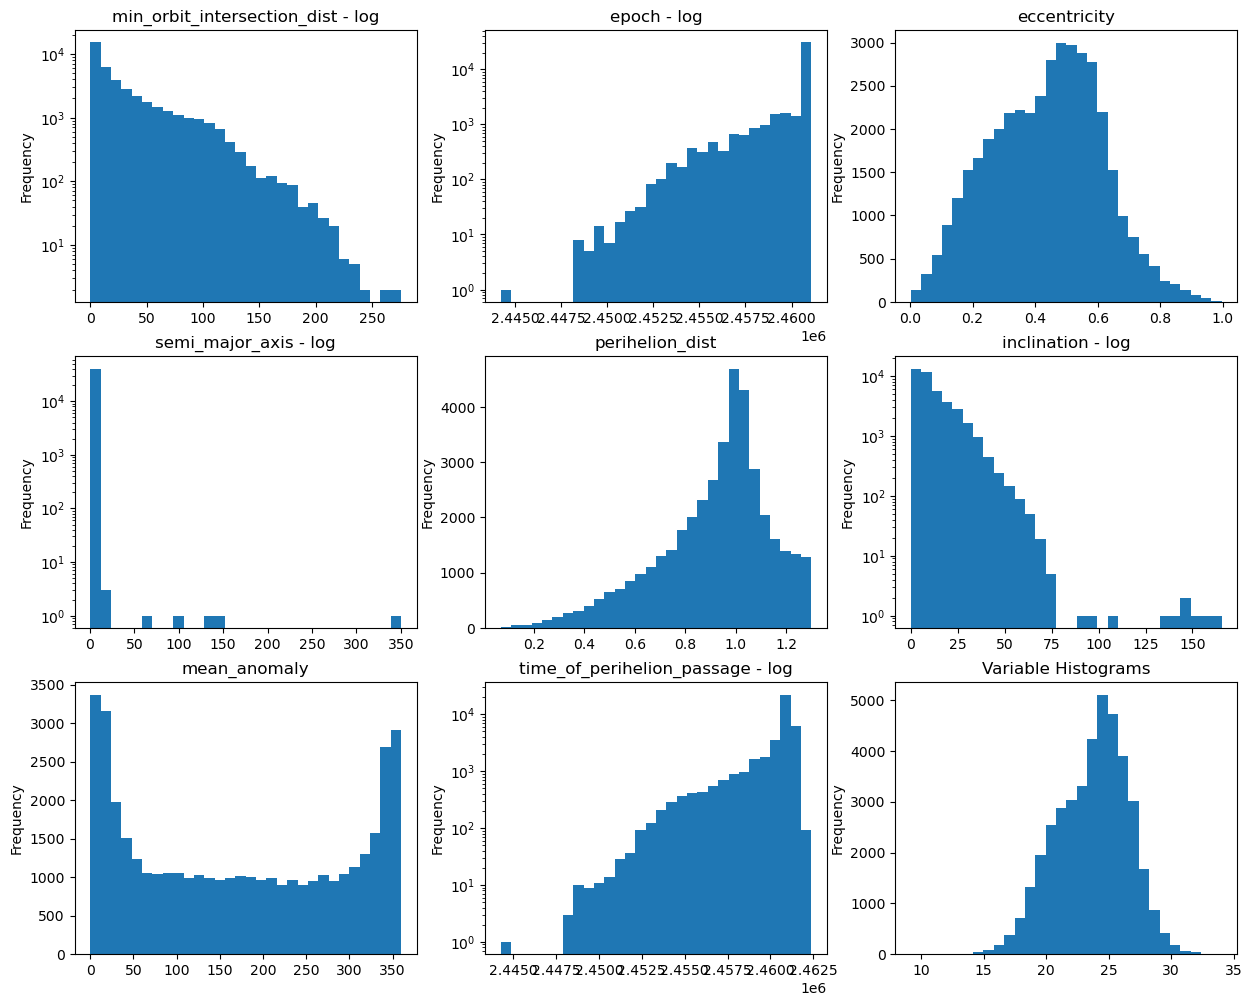

In [4]:
# Numerical variables to use
# Excluding spkid

fields = [
    'min_orbit_intersection_dist',
    'epoch',
    'eccentricity',
    'semi_major_axis',
    'perihelion_dist',
    'inclination',
    'mean_anomaly',
    'time_of_perihelion_passage',
    'abs_magnitude'
]

scales = {
    'min_orbit_intersection_dist': 'log',
    'epoch': 'log',
    'semi_major_axis': 'log',
    'inclination': 'log',
    'time_of_perihelion_passage': 'log'
}

hist_grid = make_histogram(asteroids, fields=fields, scales=scales, cols=3)

#### Multivariate

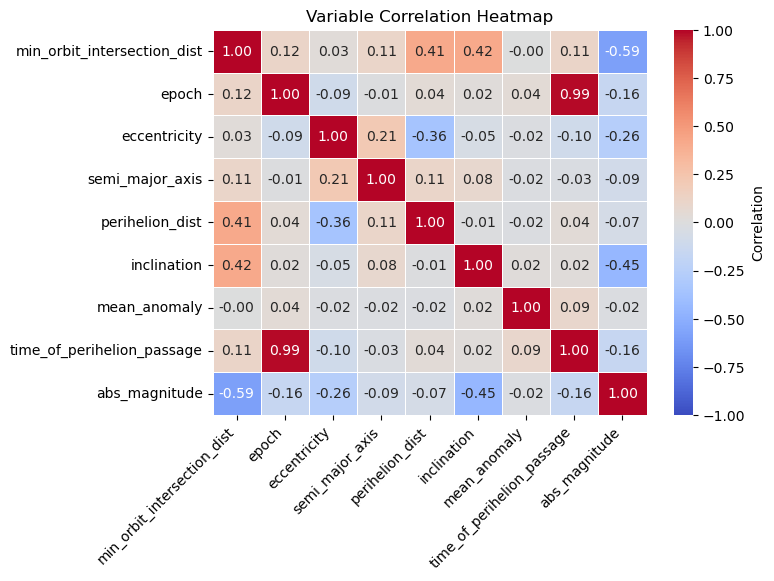

In [ ]:
# Select numeric columns, drop ID and PHA (target)
data = asteroids.select_dtypes(include='number').drop(columns=['spkid', 'pha'])

# Compute correlation
corr = data.corr()

plt.figure(figsize=(7, 5))

sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)

plt.title("Variable Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

We see a significant correlation (0.99) between `epoch` and `time_of_perihelion_passsage`. Consider that `epoch` indicates the epoch of osculation in Julian day form. Then, this correlation makes sense and is expected given that perihelion time ($T_p$) is related to epoch by:

$$
T_p \approx \text{epoch} - \text{fraction of orbital period}
$$

Perihelion passage is within one orbital period of the epoch which creates a near-linear relationship, and is thus reflected in a highly linear correlation. In other words, these two variables are not independent measurements but rather computed relative to the other, i.e., a spurious correlation.

When modeling, we will not use both variables as features.

#### Outliers

Outliers may not necessarily indicate statistical noise in this dataset, but could rather indicate rare phenomena. We thus examine outliers via both statistical methods and visual methods.

In [4]:
# IQR

numeric_cols = asteroids.select_dtypes(include='number').drop(columns=['spkid'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

iqr_outliers = (numeric_cols < lower) | (numeric_cols > upper)
iqr_counts = iqr_outliers.sum()
iqr_counts

min_orbit_intersection_dist    2024
epoch                          8538
eccentricity                     21
semi_major_axis                  73
perihelion_dist                1102
inclination                    1590
mean_anomaly                      0
time_of_perihelion_passage     6675
abs_magnitude                   119
dtype: int64

There are quite a lot of outliers flagged by IQR. However, this is expected given that IQR assumes a roughly symmetric distribution. In the histograms plotted earlier, we observed long tails, multiple peaks, and skewed distributions.

We use Empirical Cumulative Distribution Function (ECDF) plots to visualize the distribution with every data point, and no binning or smoothing [[2]](#References).

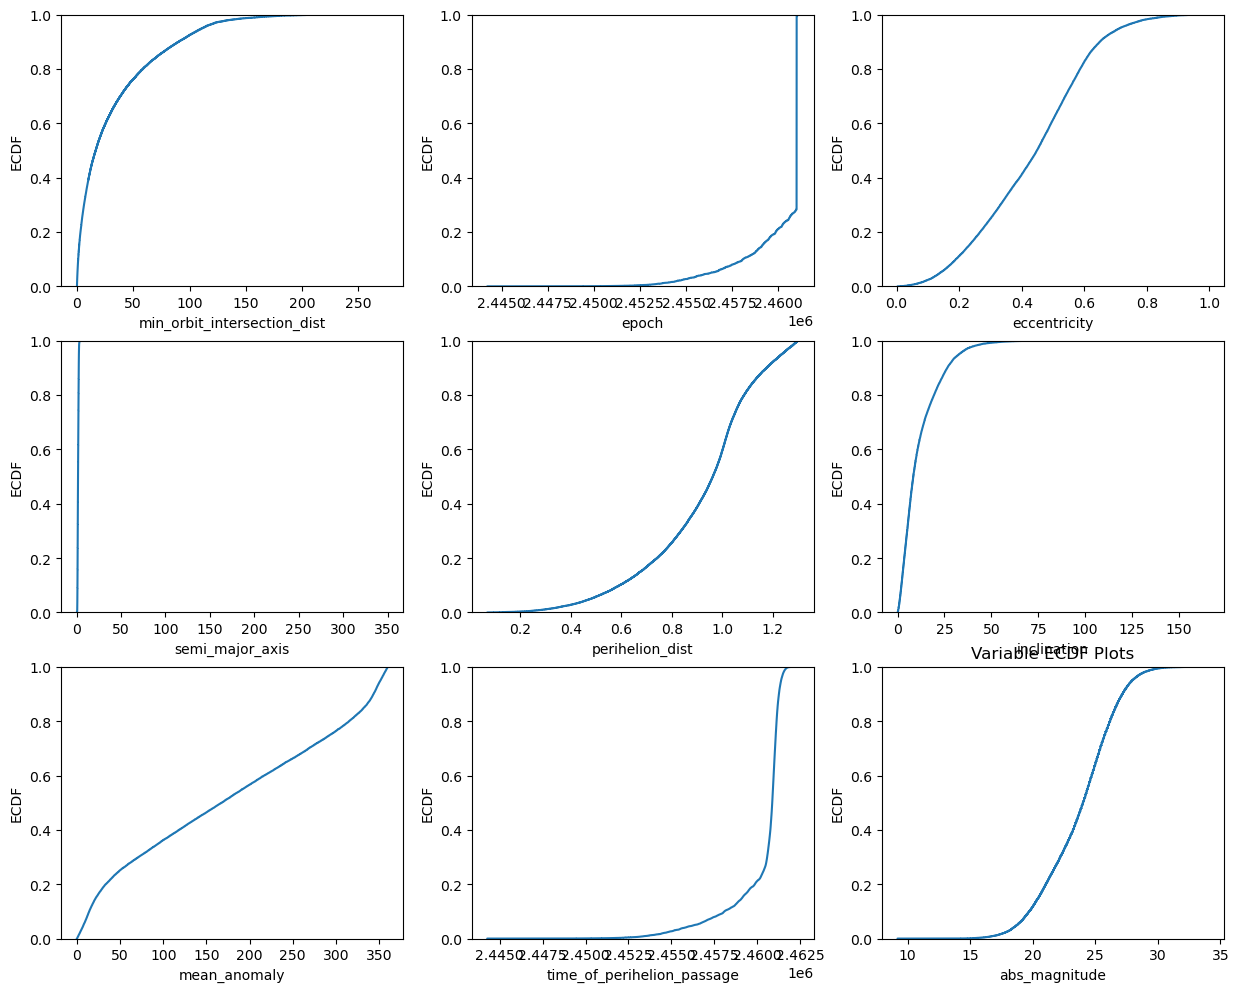

In [ ]:
# ECDF plots

numeric_cols = asteroids.select_dtypes(include='number').drop(columns=['spkid', 'pha'])

# Grid layout
grid_cols = 3
n = len(numeric_cols.columns)
rows = (n + grid_cols - 1) // grid_cols

fig, axes = plt.subplots(rows, grid_cols, figsize=(5*grid_cols, 4*rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols.columns):
    sns.ecdfplot(
        data=asteroids,
        x=col,
        ax=axes[i]
    )
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("ECDF")

plt.title('Variable ECDF Plots')
plt.show()

Outliers are expected given the particular domain and variables. Particuarly, since `epoch` values are reference times, rather than physical variables, this is expected. This stands for `time_of_perihelion_passage` as well. For `semi_major_axis`, this also makes sense given the different orbital populations that are present, e.g., near-earth and main belt. Additionally, the outliers in `min_orbit_intersection_dist` could indicate meaning rather than noise such that low MOID signifies hazardous objects, making this variable likely a strong feature to use when modeling.

#### Initial feature selection

We use robust scaling and kernel density estimation (KDE) plots to investigate structure for potential feature variables compared to the target variable (PHA).

In [6]:
drop_cols = [
    'spkid', # ID
    'full_name',
    'pdes',
    'orbit_id',
    'epoch', # non-physical variables
    'time_of_perihelion_passage'
]

log_cols = [
    'semi_major_axis',
    'perihelion_dist',
    'min_orbit_intersection_dist',
    'abs_magnitude'
]

df = asteroids.copy()

# Log transform
for col in log_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# Drop raw
df = df.drop(columns=log_cols)

# Features
X = df.drop(columns=drop_cols + ['pha'])

# Scale
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['pha'] = df['pha'].values
scaled_df.head()

,eccentricity,inclination,mean_anomaly,log_semi_major_axis,log_perihelion_dist,log_min_orbit_intersection_dist,log_abs_magnitude,pha
0,-0.861122,0.198401,0.585782,-0.267478,0.606227,0.557185,-4.694924,0
1,0.374285,0.259069,0.299081,0.939322,0.814089,0.696325,-2.446289,0
2,0.468142,0.081164,-0.352986,0.798094,0.357120,0.276542,-3.123353,0
3,0.323159,1.497848,-0.287193,0.962943,0.974255,0.942430,-5.359669,0
4,-0.053033,0.283665,-0.441816,0.263017,0.441110,0.413215,-1.838297,0


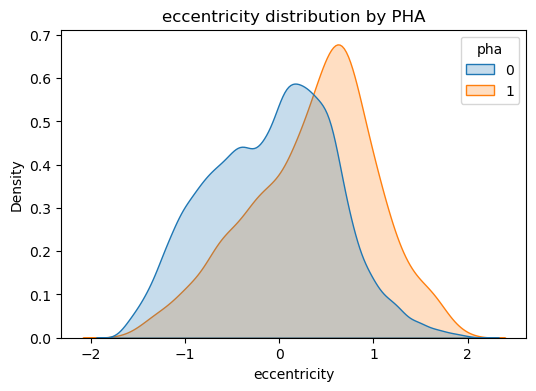

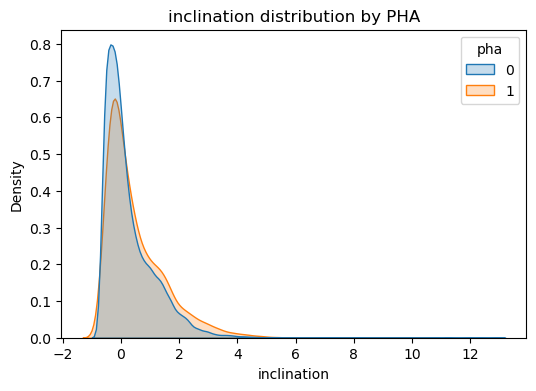

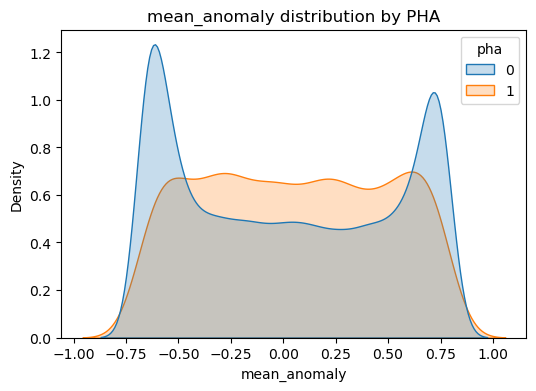

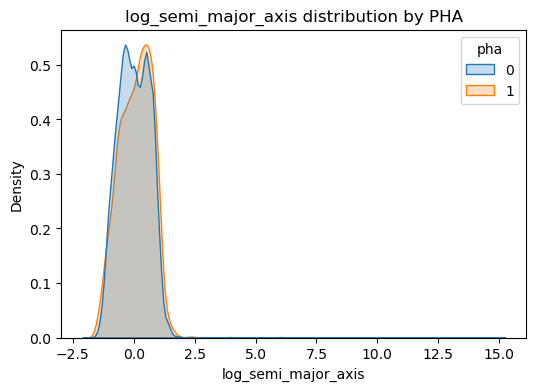

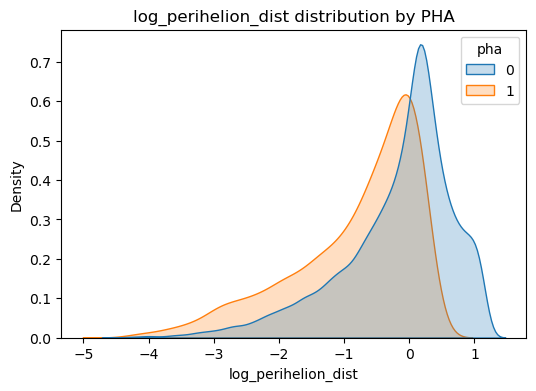

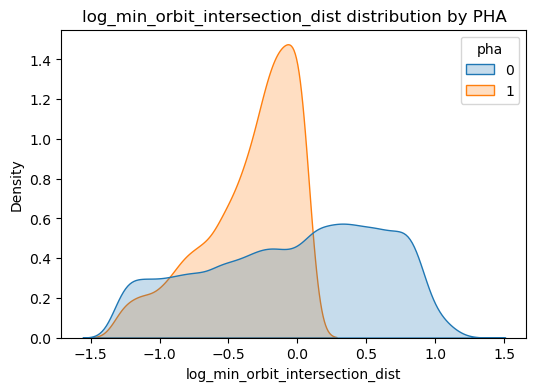

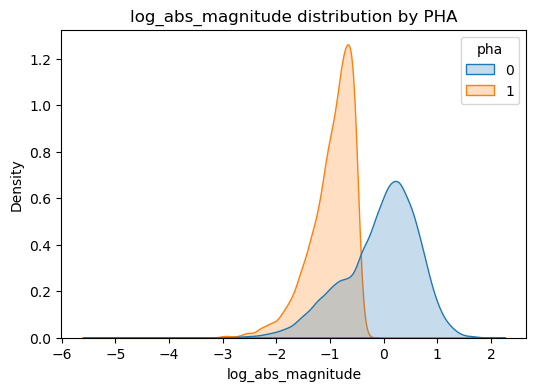

In [ ]:
predictors = scaled_df.select_dtypes(include='number').drop(columns=['pha'])
predictor_cols = predictors.columns.tolist()

for col in predictor_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=scaled_df, x=col, hue='pha', fill=True, common_norm=False)
    plt.title(f"{col} distribution by PHA")
    plt.show()

From these KDE plots, we can see that the absolute magnitude and MOID features may be strong features for prediction, given that both demonstrate significant peaks for PHA=1 compared to PHA=0. To a lesser extent, eccentricity demonstrates this as well. Conversely, inclination and perihelion distance have higher peaks for PHA=0 compared to PHA=1. Mean anomaly may be another feature to use, given that PHA=0 shows a strong multimodal distribution compared to PHA=1. Semi-major axis may be a feature to drop given the significant overlap between classes.

### Data preprocessing

Split into train (60%), validation (20%), and test sets (20%).

In [18]:
# Split into train/val/test

# Features and target
# Dropping semi major axis as selected above
X = scaled_df.drop(columns=['pha', 'log_semi_major_axis'])
y = scaled_df['pha']

# Split 1: train and val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # stratify given target class imbalance
    random_state=42
)

# Split 2: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

print("Train set:", X_train.shape)
print("Val set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (24426, 6)
Val set: (8142, 6)
Test set: (8142, 6)


### Binary classification

To predict whether a near-earth object is a potentially hazardous asteroid (PHA), we use binary classification. Given the constraint of using methods presented in DSCI 100, we use a KNN classifier with `sklearn` [[3]](#References), the only classification method discussed in the course.

We use a pipeline to robust scale the data and model with the KNN classifier, and use random search 5-fold cross validation to tune parameters.

In [20]:
# Create pipeline

knn_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("knn", KNeighborsClassifier())
])

In [23]:
# Perform random search to tune parameters

# Define parameters
param_dist = {
    "knn__n_neighbors": randint(3, 50),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan", "minkowski"],
    "knn__p": [1, 2]
}

random_search = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END knn__metric=euclidean, knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__metric=euclidean, knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__metric=minkowski, knn__n_neighbors=31, knn__p=1, knn__weights=uniform; total time=   0.3s
[CV] END knn__metric=minkowski, knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time=   0.3s
[CV] END knn__metric=minkowski, knn__n_neighbors=31, knn__p=1, knn__weights=uniform; total time=   0.3s
[CV] END knn__metric=minkowski, knn__n_neighbors=31, knn__p=1, knn__weights=uniform; total time=   0.

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'knn__metric': ['euclidean', 'manhattan', ...], 'knn__n_neighbors': <scipy.stats....t 0x157f525a0>, 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strat

In [24]:
best_model = random_search.best_estimator_

print("Best params:", random_search.best_params_)
print("Best CV AUC:", random_search.best_score_)

Best params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 45, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV AUC: 0.9974639017449238


These parameters are expected given this dataset. Manhattan (L1) distance (`p=1`) is likely preferred to Euclidean (L2) distance (`p=2`) given that Euclidean distance is dominated by large-scale dimensions, is sensitive to outliers, and assumes spherical clusters. Whereas, Manhattan distance works well in high-dimensional spaces and for non-spherical clusters. Since asteroid features are physically independent dimensions and non-spherical clusters, this is expected.

Distance weighting places emphasis on closer neighbors, where uniform weighting allows all neighbors to vote equally. Thus, distance weighting is likely preferred to uniform weighting given that it gives priority to local orbital geometry such as MOID thresholds or perihelion thresholds.

A larger $k=45$ reduces sensitivty to noise, suppresses outliers, and smooths the decision boundary which fits the large structured dataset.

In [57]:
# Plotting decision boundary
from sklearn.inspection import DecisionBoundaryDisplay

X_plot = X_train[:, :2] # Selecting first 2 features
y_plot = y_train

disp = DecisionBoundaryDisplay.from_estimator(
    best_model,
    X_plot,
    response_method="predict",
    alpha=0.5
)

plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Decision Boundary")
plt.show()

InvalidIndexError: (slice(None, None, None), slice(None, 2, None))

### Results and visualization

#### Validation evaluation

In [39]:
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("Validation AUC:", roc_auc_score(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

Validation AUC: 0.9977261366410529
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      7635
           1       0.99      0.58      0.73       507

    accuracy                           0.97      8142
   macro avg       0.98      0.79      0.86      8142
weighted avg       0.97      0.97      0.97      8142



We can see that recall is low compared to precision, particularly for PHA=1. Since PHA=1 is a rare event in the dataset, we will tune the threshold to maximize recall since false negatives (missing a PHA) are worse than false positives before evaluating on the test set. 

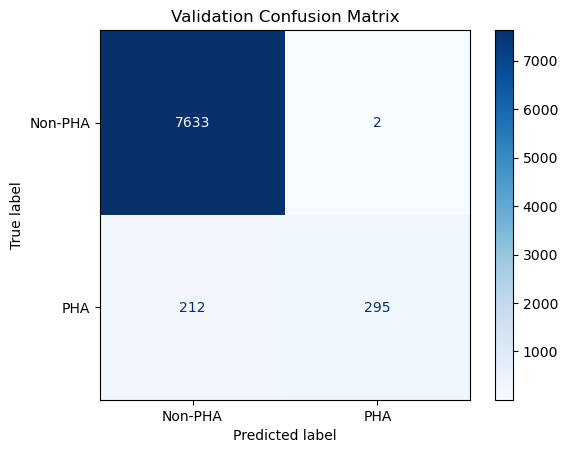

In [40]:
# Confusion matrix

cm_val = confusion_matrix(y_val, y_val_pred)
plot_cm_val = ConfusionMatrixDisplay(cm_val, display_labels=["Non-PHA", "PHA"])
plot_cm_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

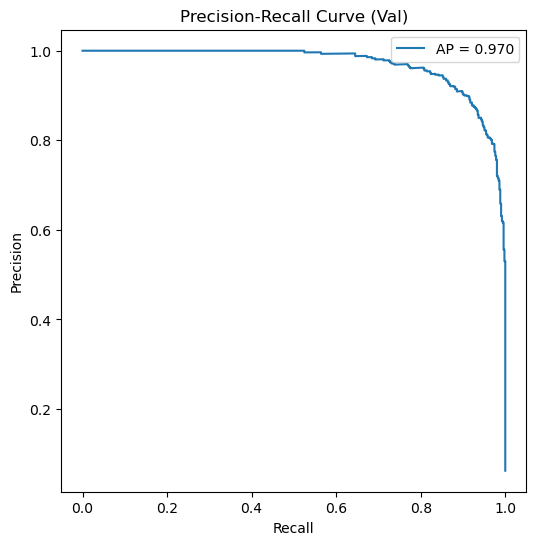

In [41]:
# PR curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
avg_prec = average_precision_score(y_val, y_val_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Val)")
plt.legend()
plt.show()

#### Threshold tuning

In [44]:
min_precision = 0.85
valid = precision[:-1] >= min_precision

best_idx = np.argmax(recall[:-1][valid])
best_thresh = thresholds[valid][best_idx]
print("Best threshold:", best_thresh)

Best threshold: 0.24555202065736537


#### Test evaluation

In [45]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_thresh = (y_test_proba >= best_thresh).astype(int)

print("Test AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_thresh))

Test AUC: 0.9971823417795913
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7635
           1       0.81      0.94      0.87       507

    accuracy                           0.98      8142
   macro avg       0.90      0.96      0.93      8142
weighted avg       0.98      0.98      0.98      8142



We can see better recall on the test set, after using the tuned threshold.

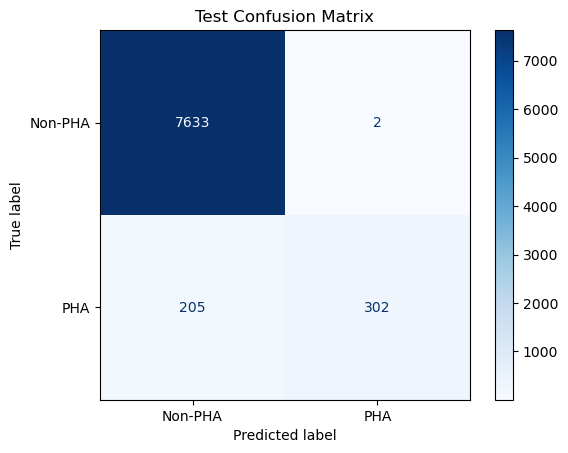

In [46]:
# Confusion matrix

cm_test = confusion_matrix(y_test, y_test_pred)
plot_cm_test = ConfusionMatrixDisplay(cm_test, display_labels=["Non-PHA", "PHA"])
plot_cm_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

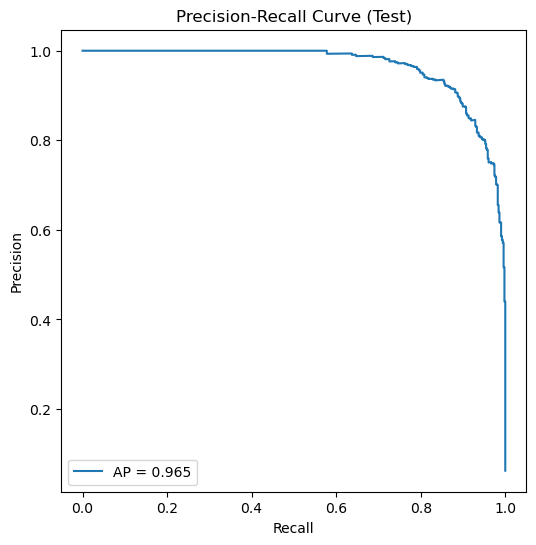

In [47]:
# PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
avg_prec = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.show()

Recall@K curve: given top $k$ asteroids, how many PHAs are detected?

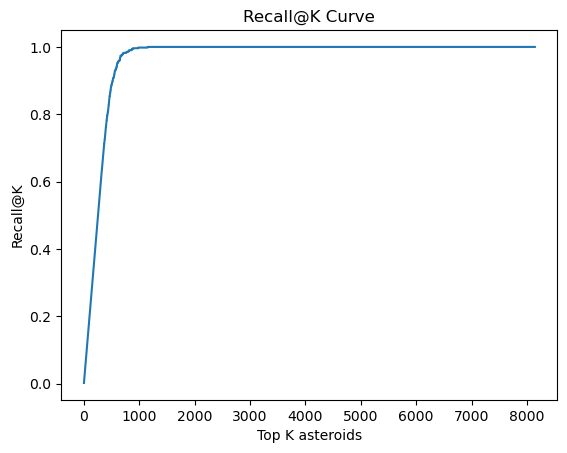

In [50]:
# Recall@K curve 

sorted_idx = np.argsort(-y_test_proba)
sorted_y = y_test.values[sorted_idx]

k_vals = np.arange(1, len(sorted_y)+1)
recall_at_k = np.cumsum(sorted_y) / sorted_y.sum()

plt.plot(k_vals, recall_at_k)
plt.xlabel("Top K asteroids")
plt.ylabel("Recall@K")
plt.title("Recall@K Curve")
plt.savefig('../results/recall_at_k.png')
plt.show()

Probability distributions by class: examine class separability in probability space

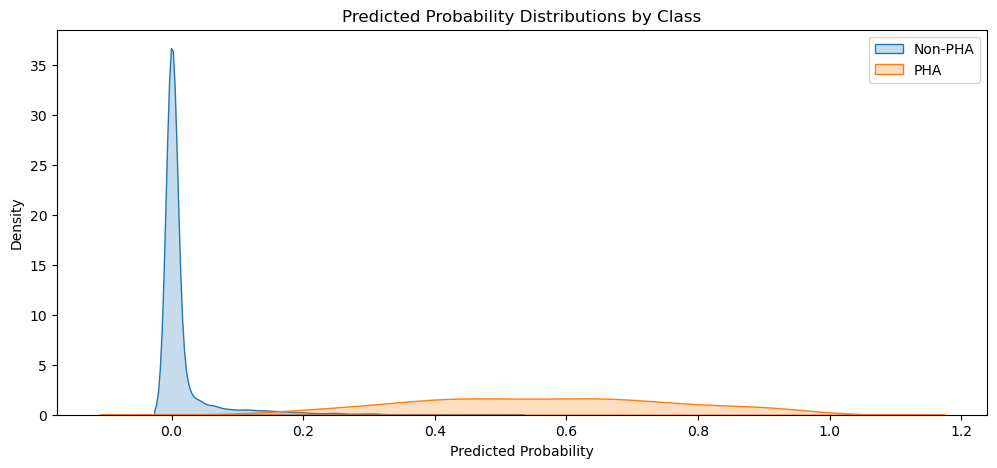

In [56]:
# Probability distributions by class

plt.figure(figsize=(12, 5))
sns.kdeplot(y_test_proba[y_test==0], label='Non-PHA', fill=True)
sns.kdeplot(y_test_proba[y_test==1], label='PHA', fill=True)
plt.xlabel("Predicted Probability")
plt.title("Predicted Probability Distributions by Class")
plt.legend()
plt.savefig('../results/prob_dist_by_class.png')
plt.show()

We can see fairly clear separation between classes. Examining the decision boundary, we see the same result.

## Discussion

## References

1. https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html
2. https://seaborn.pydata.org/generated/seaborn.ecdfplot.html
3. https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification